In [1]:
## Imports ##
#------------------------------------------------#
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.autograd as autograd
#------------------------------------------------#
import matplotlib.pyplot as plt
import numpy as np
from time import time
import math
import os
import sys
from tqdm import tqdm
#------------------------------------------------#
from data import Dataset
from train_isola import SiameseNetwork
#------------------------------------------------#
import scipy.spatial as sp 
import scipy.cluster.hierarchy as hc
from scipy.cluster.hierarchy import dendrogram
import seaborn as sns
#------------------------------------------------#

/home/gefenkohavi/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Device mode:  cpu


In [8]:
is_depth = False
if is_depth:
    model = torch.load('model_isola', map_location='cpu')#.cuda()
else:
    model = torch.load('model_isola_nodepth', map_location='cpu')#.cuda()
model.eval()
#Testing
batch_size = 256
accuracy = []
trainset = Dataset(train=True, split_size=.8, patches=False)
ts = trainset
trainloader = DataLoader(dataset=trainset, batch_size=batch_size)
# Dataset intrinsics
skip_len = trainset.skip_len-1
ps = trainset.ps
shape = trainset.shape


def get_neighbors(x, y):
    xyc = [(x+skip_len, y), (x-skip_len, y), (x+skip_len, y+skip_len), (x-skip_len, y+skip_len),
           (x+skip_len, y-skip_len), (x-skip_len, y-skip_len), (x, y+skip_len), (x, y-skip_len)]
    xyc = filter(lambda x: ps<x[0]<shape[0]-ps and 
                              ps<x[1]<shape[1]-ps, xyc)
    xyc = list(xyc)
    return xyc
def np_img2torch(img):
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2)
#     img = img.cuda()
    return img
def torch_img2np(img):
    img = img.permute(0, 2, 3, 1)
    img = img.detach().cpu().numpy()
    img = img.squeeze(0)
    return img

(480, 640, 4)
100 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


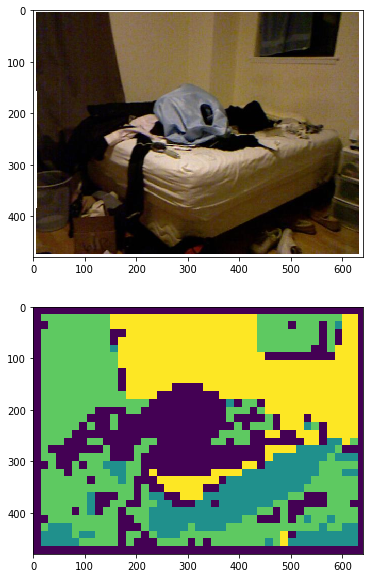

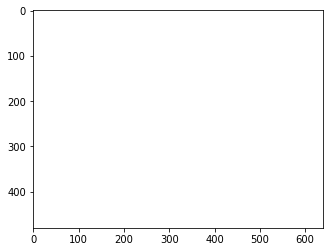

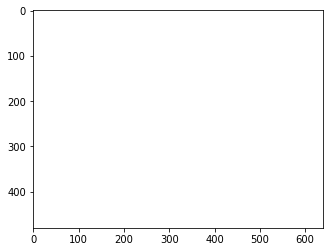

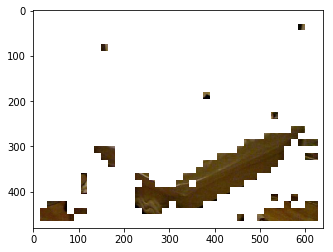

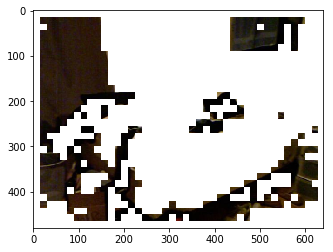

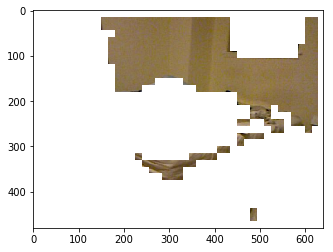

In [11]:
# Fake Clustering
dists = []
dists_idx = []
with torch.no_grad():
    # Construct tree
    img_ = trainset[59] #11
    for i in [3]: # todo, didn't actually train with all chanels normalized
        img_[:,:,i] = (img_[:,:,i]-np.mean(img_[:,:,i])) / np.std(img_[:,:,i])
    start = time()
    # img_ = np_img2torch(img_)
    print(img_.shape)
    A_x, A_y = 100, 300 #trainset.choose_rand_patch() #270, 135
    print(A_x, A_y)

    # show how close nieghbors are
    show_img_ = np.copy(img_)
    
    num_clusters = 5
    img_mask = np.zeros((show_img_.shape[0], show_img_.shape[1]))
    
    img_ = np_img2torch(img_)

    
    
    for cluster_at in range(num_clusters):
        flag = False # don't take x, y inside a cluster
        while not flag:
            A_x, A_y = int(np.random.uniform(0, 620)), int(np.random.uniform(0, 460))
            if np.count_nonzero(img_mask[A_x-ps:A_x+ps+1, A_y-ps:A_y+ps+1]) < 3:
                flag=True
        A = ts.get_from_xy(A_x, A_y, img_)
        for di, i in enumerate(range(ps, shape[0], skip_len)):
            for dj, j in enumerate(range(ps, shape[1], skip_len)):
                B = ts.get_from_xy(i, j, img_)
                if A.shape != B.shape: # happens when reading corner
                    C = 0
                else:
                    if is_depth:
                        C = model(A, B)[0][0].item()
                    else: 
                        C = model(A[:,:3,:,:], B[:,:3,:,:])[0][0].item()
                # show white
                if C > .7:
                    img_mask[i-ps:i+ps+1, j-ps:j+ps+1] = cluster_at+1
#                     show_img_[i-ps:i+ps+1, j-ps:j+ps+1,:] = .3*C + show_img_[i-ps:i+ps+1, j-ps:j+ps+1,:]*.7
    #             show_img_[i-ps:i+ps+1, j-ps:j+ps+1,1] *= (1-C) 
    plt.figure(figsize=(10,10))
    #     show_img_[A_x-ps:A_x+ps+1, A_y-ps:A_y+ps+1,:] = 0
    plt.subplot(2, 1, 1)
    plt.imshow(show_img_[:,:,:3])
    plt.subplot(2, 1, 2)
    plt.imshow(img_mask)
    for i in range(num_clusters):
        plt.figure()
        maski = np.expand_dims(np.copy(img_mask), 2)
        maski[maski != i] = 0
#         if np.sum(maski) == 0 and i != 0:
#             continue
        plt.imshow(np.dstack([show_img_[:,:,:3], maski]))
    plt.show()

(480, 640, 4)
270 135


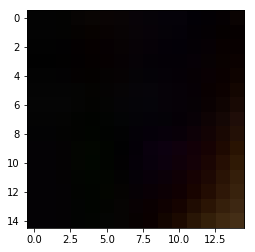

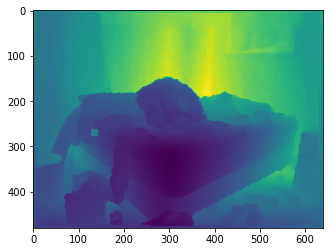

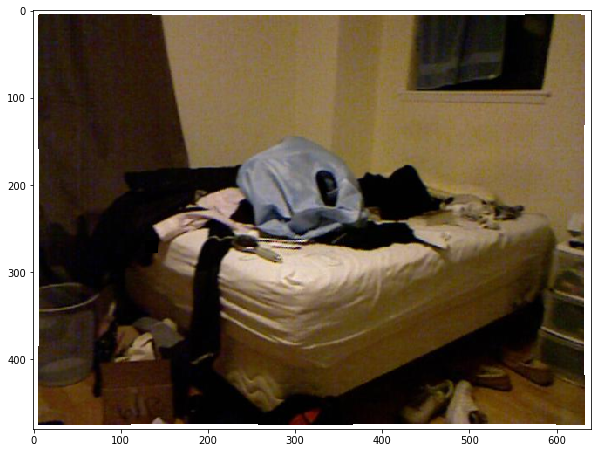

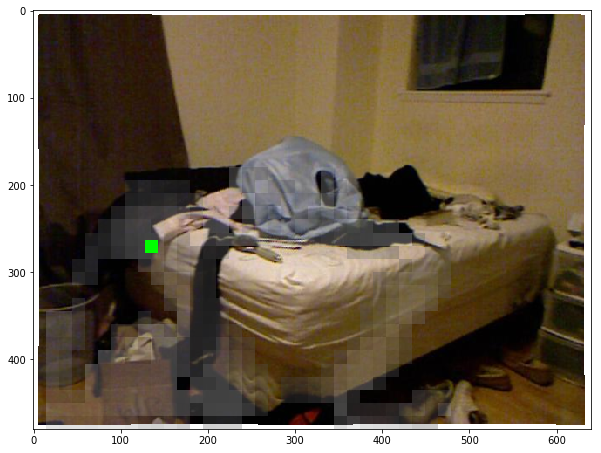

In [35]:
dists = []
dists_idx = []
with torch.no_grad():
    # Construct tree
    img_ = trainset[59] #11
    for i in [3]: # todo, didn't actually train with all chanels normalized
        img_[:,:,i] = (img_[:,:,i]-np.mean(img_[:,:,i])) / np.std(img_[:,:,i])
    start = time()
    # img_ = np_img2torch(img_)
    print(img_.shape)
    A_x, A_y = 270, 135#trainset.choose_rand_patch() #270, 135
    print(A_x, A_y)
    show_img_ = np.copy(img_)
    plt.figure()
    plt.imshow(show_img_[A_x-ps:A_x+ps+1, A_y-ps:A_y+ps+1,:][:,:,:3])
    show_img_[A_x-ps:A_x+ps+1, A_y-ps:A_y+ps+1,:] = 0
    plt.figure()
    plt.imshow(show_img_[:,:,3])
    plt.figure(figsize=(10,10))
    plt.imshow(show_img_[:,:,:3])
    plt.show()
    # 1/0
    # plt.show()
    # show how close nieghbors are
    show_img_ = np.copy(img_)
    img_ = np_img2torch(img_)

    A = ts.get_from_xy(A_x, A_y, img_)
    for di, i in enumerate(range(ps, shape[0], skip_len)):
        for dj, j in enumerate(range(ps, shape[1], skip_len)):
            B = ts.get_from_xy(i, j, img_)
            if A.shape != B.shape: # happens when reading corner
                C = 0
            else:
                if is_depth:
                    C = model(A, B)[0][0].item()
                else: 
                    C = model(A[:,:3,:,:], B[:,:3,:,:])[0][0].item()
            # show white
            if C > .3:
                show_img_[i-ps:i+ps+1, j-ps:j+ps+1,:] = .3*C + show_img_[i-ps:i+ps+1, j-ps:j+ps+1,:]*.7
#             show_img_[i-ps:i+ps+1, j-ps:j+ps+1,1] *= (1-C) 
    show_img_[A_x-ps:A_x+ps+1, A_y-ps:A_y+ps+1,0] = 0
    show_img_[A_x-ps:A_x+ps+1, A_y-ps:A_y+ps+1,1] = 1
    show_img_[A_x-ps:A_x+ps+1, A_y-ps:A_y+ps+1,2] = 0
    plt.figure(figsize=(10,10))
    plt.imshow(show_img_[:,:,:3])
    plt.show()



    # for di1, i1 in enumerate(range(ps, shape[0], skip_len)):
    #     for dj1, j1 in enumerate(range(ps, shape[1], skip_len)):
    #         img1 = img_[:,:,i1-ps:i1+ps+1,j1-ps:j1+ps+1]
    #         img1_neighbors = get_neighbors(i1, j1)

    #         for di2, i2 in enumerate(range(ps, shape[0], skip_len)):
    #             for dj2, j2 in enumerate(range(ps, shape[1], skip_len)):
    #                 if (i2, j2) in img1_neighbors:
    #                     img2 = img_[:,:,i2-ps:i2+ps+1,j2-ps:j2+ps+1]

    #                     # feeding in the same image should result in a low number
    #                     # print(img1.shape, img2.shape)
    #                     dists.append(model(img1, img2))
    #                     dists_idx.append(([di1, dj1], [di2, dj2]))
    #                 else:
    #                     # dists.append(500)
    #                     pass
    #                     # dists_idx.append(([di1, dj1], [di2, dj2]))
    #         print(i1, j1)
    # end = time()
    # print(end-start)

/home/gefenkohavi/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


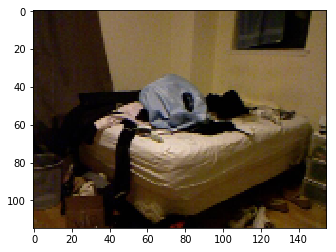

(115, 155, 3)


In [65]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from skimage.transform import rescale, resize, downscale_local_mean
plt.figure()
img_2 = show_img_[10:-10,10:-10,:3]
img_r = image_resized = resize(img_2, (img_2.shape[0]//4, img_2.shape[1]//4))
plt.imshow(img_r[:,:,:])
plt.show()
# img_r = img_r[:,:,-1]
graph = image.img_to_graph(img_r)
print(img_r.shape)

In [ ]:
# graph.data = np.exp(-graph.data / graph.data.std())
print("Started Clustering")
labels = spectral_clustering(graph, n_clusters=7, eigen_solver='arpack')
labels = np.reshape(labels, (img_r.shape[0], img_r.shape[1], 3))

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.imshow(img_r)
plt.subplot(2, 1, 2)
labels = np.sum(labels, axis=2)
plt.imshow(labels)
# plt.colorbar()
plt.show()

Started Clustering


In [51]:
np.max(labels[:,:,:3 ])

6

In [ ]:
graph